<a href="https://colab.research.google.com/github/DunkleCat/ia-esame/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caricamento del dataframe

In [69]:
import pandas as pd

def io_load_multiple_csv(csv_path_list):
  dataframe_list = []
  for elem in csv_path_list:
    dataframe_list.append(io_load_csv(elem))
  return dataframe_list

def io_load_csv(csv_path):
  return pd.read_csv(csv_path)  

# Analisi del Dataset


## Pulizia valori nulli

Come primo passaggio cerchiamo di sfruttare le potenzialità di sklearn per recuperare tutte quelle righe che presentano valori nulli e renderle valide.


In [70]:
#from sklearn.impute import SimpleImputer
import numpy as np

def normalize_nan(dataframe, nan_list):
  for elem in nan_list:
    dataframe.replace(elem, np.nan, inplace=True)
  #imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  #imp.fit(dataframe)
  return dataframe

## Pulizia colonne poco significative

Passiamo ora ad analizzare i dati in ingresso e trovare colonne che molto probabilmente non ci aiuteranno nella previsione

In [71]:
def print_infos(dataframe):
  print("Dataframe miscellaneous:\n")
  print("Rows     : {}".format(dataframe.shape[0]) )
  print("Columns  : {}".format(dataframe.shape[1]))
  print("\nFeatures :\n{}".format(dataframe.columns.tolist()))
  print("\nUnique values :\n{}".format(dataframe.nunique()))

  print("\nDataframe info:")
  dataframe.info()

In [72]:
import matplotlib.pyplot as plt
import seaborn as sb

def print_feature_plots(dataframe, feature_list, feature_target):
  for elem in dataframe:
    if elem in feature_list:
      plot = sb.catplot(x = feature_target, 
                        col = elem, 
                        data = dataframe, 
                        kind = 'count')
    plt.show()

In [73]:
def clean_useless(dataframe, useless_list):
  for elem in useless_list:
    dataframe.pop(elem)
  return dataframe

## Da semplici dati a numeri utili

Per ogni colonna presente nel dataset, ogni suo elemento viene trasformato in un intero corrispondente ad una classe della colonna stessa, se non è già un numero.

In [74]:
from sklearn.preprocessing import LabelEncoder

def attributes_to_float(dataframe):
  le_dict = {}
  for elem in dataframe:
    if type(dataframe[elem][1]) is str:
      le_dict[elem] = LabelEncoder()
      dataframe[elem] = le_dict[elem].fit_transform(dataframe[elem])

  return dataframe, le_dict

# Modello

In [75]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestClassifier

# TODO ordine alfabetico

def create_model(dataframe):
  #imputer = FeatureUnion( 
  #    transformer_list=[('features', SimpleImputer(strategy='mean')), 
  #                      ('indicators', MissingIndicator())])
  
  numeric_features = get_numeric_features(dataframe)
  numeric_transformer = Pipeline(
      steps=[('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())])
  
  categorical_features = get_categorical_features(dataframe)
  categorical_transformer = Pipeline(
      steps=[#('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
             ('imputer', SimpleImputer(strategy='most_frequent')),
             #('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])
             ('onehot', OneHotEncoder(handle_unknown='ignore'))])

  preprocessor = ColumnTransformer(
      transformers=[('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

  reduce_dim = TruncatedSVD()

  classifier = RandomForestClassifier()

  regressor = Ridge()

  return Pipeline([#('imputer', imputer),
                   #('fix_mixed_types', fix_mixed_types),
                   #('scaler', scaler),
                   ('preprocessor', preprocessor),
                   ('reduce_dim', reduce_dim),
                   #('classifier', classifier)
                   ('regressor', regressor)
                   ])

def get_numeric_features(dataframe):
  numeric_features = []
  for elem in dataframe:
    if is_numeric(dataframe[elem]):
      numeric_features.append(elem)
  return numeric_features

def get_categorical_features(dataframe):
  categorical_features = []
  for elem in dataframe:
    if is_categorical(dataframe[elem]):
      categorical_features.append(elem)
  return categorical_features

def is_numeric(elem):
  return elem is float or elem is int

def is_categorical(elem):
  return not is_numeric(elem)

In [76]:
from sklearn import set_config

def print_model(model):
  #set_config(display='diagram')
  model

In [77]:
from sklearn.model_selection import GridSearchCV

def train_model(model, dataframe_train, dataframe_train_target):
  #return model.fit(dataframe_train, dataframe_train_target)
  n_features_to_test = np.arange(1, dataframe_train.shape[1])
  alpha_to_test = 2.0**np.arange(-6, +6)
  params = {
      'reduce_dim__n_components': n_features_to_test, 
      'regressor__alpha': alpha_to_test
      }
  return GridSearchCV(model, params, verbose=1).fit(dataframe_train, 
                                                    dataframe_train_target)

In [78]:
def print_test_model(model, dataframe_test, dataframe_test_target):
  print('Test Score: {}'.format(model.score(dataframe_test, 
                                               dataframe_test_target)))
  print('Best params: {}'.format(model.best_params_))

# Esecuzione

In [79]:
## MISCELLANEOUS ###############################################################

# !pip install -r requirements.txt

# Rende i numeri a virgola mobile più leggibili
np.set_printoptions(precision=3, suppress=True)

################################################################################

In [80]:
## MANUAL INTERVENTION #########################################################

dataframe_train_path = "./train.csv"
dataframe_test_path = "./test.csv"
#dataframe_train_path = "/content/drive/My Drive/ia-esame/train.csv"
#dataframe_test_path = "/content/drive/My Drive/ia-esame/test.csv"

################################################################################

## EXECUTION ###################################################################


#dataframe_train = io_load_csv(dataframe_train_path)
#dataframe_test = io_load_csv(dataframe_test_path)

dataframe_train, dataframe_test = io_load_multiple_csv([dataframe_train_path, 
                                                        dataframe_test_path])

################################################################################

In [81]:
dataframe_train.head()

,No-show,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,No,2.647823e+12,5626550,M,2016-04-27T08:22:02Z,2016-05-05T00:00:00Z,63,ILHA DO PRÍNCIPE,0,1,1,0,0,1
1,No,2.772585e+14,5680940,F,2016-05-10T13:18:27Z,2016-05-13T00:00:00Z,52,SANTO ANTÔNIO,0,0,0,0,0,0
2,No,5.378235e+13,5679296,F,2016-05-10T09:44:35Z,2016-05-10T00:00:00Z,46,CENTRO,0,1,0,0,0,0
3,No,2.711119e+13,5621478,F,2016-04-26T10:21:41Z,2016-05-02T00:00:00Z,31,DA PENHA,0,0,0,0,0,0
4,No,8.328715e+10,5671891,F,2016-05-09T07:22:43Z,2016-05-11T00:00:00Z,50,CONQUISTA,0,0,0,0,0,0


Dataframe miscellaneous:

Rows     : 70736
Columns  : 14

Features :
['No-show', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']

Unique values :
No-show               2
PatientId         46573
AppointmentID     70736
Gender                2
ScheduledDay      67701
AppointmentDay       27
Age                 103
Neighbourhood        81
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handcap               5
SMS_received          2
dtype: int64

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   No-show         70736 non-null  object 
 1   PatientId       70736 non-null  float64
 2   AppointmentID   70736 non-null  int64  
 3   Gender         

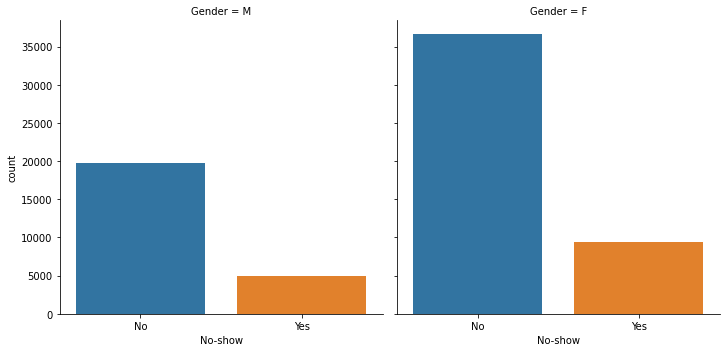

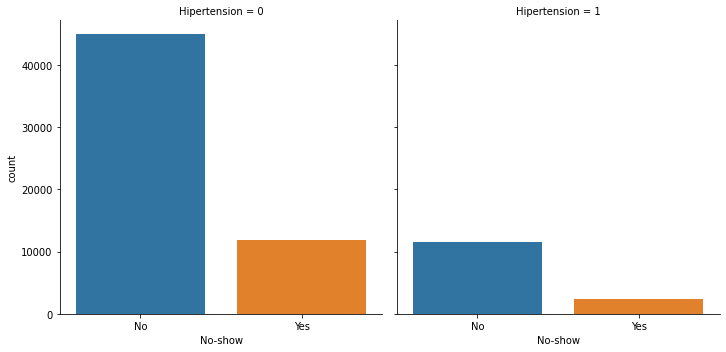

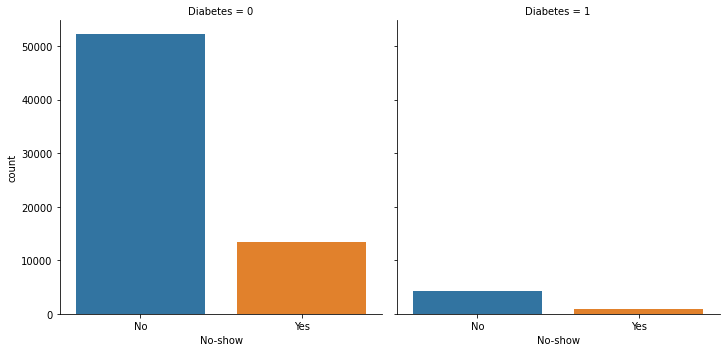

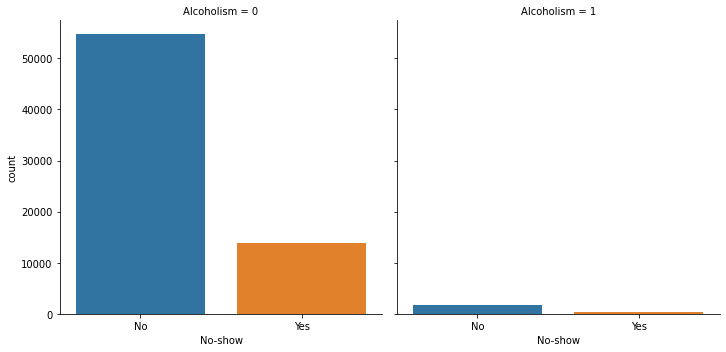

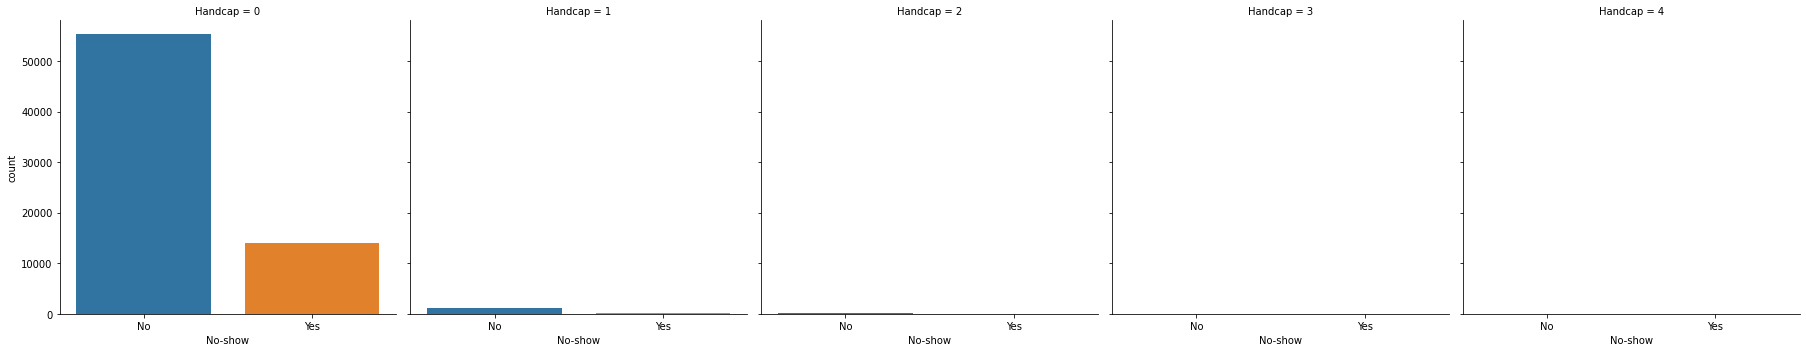

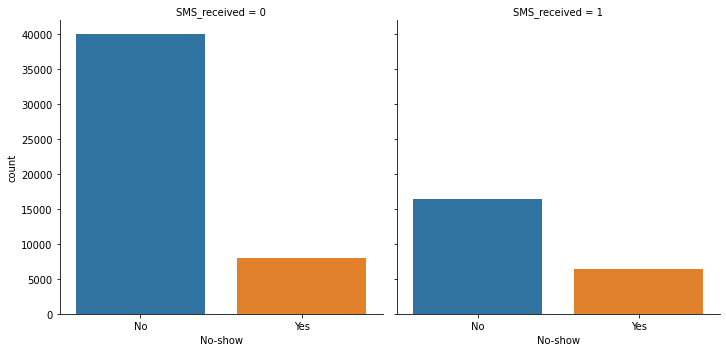

In [82]:
## MANUAL INTERVENTION #########################################################

nan_list = [
            "", 
            " ", 
            "?",
            "unknown"
] # All the ways a nan element appears inside the dataframe

feature_list = [
                "Gender",
                "Hipertension",
                "Diabetes",
                "Alcoholism",
                "Handcap",
                "SMS_received"
] # All the useful features to plot 

feature_target = "No-show"

################################################################################

## EXECUTION ###################################################################

# TODO Investigare l'utilizzo di map che ritorna valori _o_ 
#      substitute che agisce in utomatico senza a = a.sub(b)

# Clean the dataframe from nan values
dataframe_train = normalize_nan(dataframe_train, nan_list)
dataframe_test = normalize_nan(dataframe_test, nan_list)

# Print dataframe's infographic
print_infos(dataframe_train)
print_feature_plots(dataframe_train, feature_list, feature_target)

################################################################################

In [83]:
## MANUAL INTERVENTION #########################################################

useless_list = [
                #"PatientId",
                "AppointmentID",
                "ScheduledDay"        
] # All the meaningless attributes in relation to the prediction 

################################################################################

## EXECUTION ###################################################################

# Clean the dataframe from meningless attributes
dataframe_train = clean_useless(dataframe_train, useless_list)
dataframe_test = clean_useless(dataframe_test, useless_list)

# Transform every column in a float value
# dataframe_train, label_encoder_dict = attributes_to_float(dataframe_train)

################################################################################

In [84]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


## MANUAL INTERVENTION #########################################################

feature_target = "No-show"

################################################################################

# TODO LE cose che chiamo due volte devono diventare la chiamata ad una funzione sola

## EXECUTION ###################################################################

# lb = LabelBinarizer()
le = LabelEncoder()

# dataframe_train_target = lb.fit_transform(dataframe_train.pop(feature_target))
# dataframe_test_target = lb.fit_transform(dataframe_test.pop(feature_target))

dataframe_train_target = le.fit_transform(dataframe_train.pop(feature_target))
dataframe_test_target = le.fit_transform(dataframe_test.pop(feature_target))

# Create the model
model = create_model(dataframe_train)
print_model(model)

# Train the model
model = train_model(model, dataframe_train, dataframe_train_target)

# Test the model
print_test_model(model, dataframe_test, dataframe_test_target)

################################################################################

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 19.9min finished


Test Score: 0.790048063330506
